# Lexical Diversity Analysis

This notebook defines a new metric called "Lexical Diversity" to analyze the vocabulary richness of a text. 
We'll compare an original essay with its LLM-generated counterpart using this metric.

Lexical diversity measures how varied the vocabulary is in a text. It can help identify:
- Vocabulary richness
- Word repetition patterns
- Language sophistication

We'll implement several lexical diversity metrics:
1. Type-Token Ratio (TTR)
2. Moving Average TTR (MATTR)
3. Measure of Textual Lexical Diversity (MTLD)

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns

# Add the parent directory to sys.path to import modules
current_dir = os.getcwd()
print("Current working directory", current_dir)

root_dir = os.path.dirname(current_dir)  # Get artistotllm root directory
if root_dir not in sys.path:
    sys.path.append(root_dir)
    print(f"Added {root_dir} to sys.path")

# Now we can import from src
try:
    from src.evaluation.pos_similarity import read_file
    from src.utils.text_splitter import split_text
    print("Successfully imported modules from src")
except ImportError as e:
    print(f"Error importing modules: {e}")
    print("System paths:", sys.path)

Current working directory /Users/brunozorrilla/Documents/GitHub/artistotllm/notebooks
Added /Users/brunozorrilla/Documents/GitHub/artistotllm to sys.path
Successfully imported modules from src


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/brunozorrilla/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brunozorrilla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brunozorrilla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Download required nltk resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brunozorrilla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brunozorrilla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Define Lexical Diversity Metrics

### 1. Type-Token Ratio (TTR)
The simplest measure of lexical diversity is the Type-Token Ratio (TTR), which is the ratio of unique words (types) to total words (tokens) in a text.

In [3]:
def preprocess_text(text, remove_stopwords=False):
    """Preprocess text by tokenizing, lowercasing, and optionally removing stopwords."""
    tokens = word_tokenize(text.lower())
    # Remove non-alphabetic tokens
    tokens = [token for token in tokens if token.isalpha()]
    
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
    
    return tokens

def type_token_ratio(tokens):
    """Calculate Type-Token Ratio (TTR)."""
    if not tokens:
        return 0
    
    n_types = len(set(tokens))  # Number of unique words
    n_tokens = len(tokens)      # Total number of words
    
    return n_types / n_tokens

def moving_average_ttr(tokens, window_size=100):
    """Calculate Moving-Average Type-Token Ratio (MATTR)."""
    if len(tokens) < window_size:
        return type_token_ratio(tokens)
    
    # Calculate TTR for each window and take the average
    ttrs = []
    for i in range(len(tokens) - window_size + 1):
        window = tokens[i:i+window_size]
        ttrs.append(type_token_ratio(window))
    
    return sum(ttrs) / len(ttrs)

def mtld(tokens, threshold=0.72):
    """Calculate Measure of Textual Lexical Diversity (MTLD)."""
    if len(tokens) < 50:  # Too short for reliable MTLD
        return 0
    
    def mtld_pass(tokens, threshold):
        # Forward pass
        factors = 0
        types_so_far = set()
        token_count = 0
        
        for token in tokens:
            token_count += 1
            types_so_far.add(token)
            ttr = len(types_so_far) / token_count
            
            if ttr <= threshold:
                factors += 1
                types_so_far = set()
                token_count = 0
        
        if token_count > 0:
            ttr = len(types_so_far) / token_count
            partial_factor = (1 - ttr) / (1 - threshold)
            factors += partial_factor
        
        return len(tokens) / factors if factors > 0 else 0
    
    # Calculate MTLD as the average of forward and backward passes
    forward = mtld_pass(tokens, threshold)
    backward = mtld_pass(tokens[::-1], threshold)
    
    return (forward + backward) / 2

def word_frequency_distribution(tokens, top_n=20):
    """Calculate word frequency distribution."""
    counter = Counter(tokens)
    return counter.most_common(top_n)

## Load and Analyze Text

In [4]:
ORIGINAL_PATH = os.path.join(root_dir, "data/PG_sample/processed/a_plan_for_spam.txt")
GENERATED_PATH = os.path.join(root_dir, "data/PG_sample/generated/a_plan_for_spam_generated.txt")

print(f"Original file path: {ORIGINAL_PATH}")
print(f"Generated file path: {GENERATED_PATH}")

# Check if files exist
print(f"Original file exists: {os.path.exists(ORIGINAL_PATH)}")
print(f"Generated file exists: {os.path.exists(GENERATED_PATH)}")

# Read the texts
original_text = read_file(ORIGINAL_PATH)
generated_text = read_file(GENERATED_PATH)

# Split the original text into segments
first_500, second_500, rest = split_text(original_text)

Original file path: /Users/brunozorrilla/Documents/GitHub/artistotllm/data/PG_sample/processed/a_plan_for_spam.txt
Generated file path: /Users/brunozorrilla/Documents/GitHub/artistotllm/data/PG_sample/generated/a_plan_for_spam_generated.txt
Original file exists: True
Generated file exists: True


In [5]:
# Print sample information
print(f"Original text length: {len(original_text.split())} words")
print(f"Generated text length: {len(generated_text.split())} words")
print(f"First 500 words length: {len(first_500.split())} words")

Original text length: 5237 words
Generated text length: 470 words
First 500 words length: 500 words


## Calculate Lexical Diversity Metrics

In [6]:
# Preprocess the texts
original_tokens = preprocess_text(first_500)
generated_tokens = preprocess_text(generated_text)
original_tokens_no_stopwords = preprocess_text(first_500, remove_stopwords=True)
generated_tokens_no_stopwords = preprocess_text(generated_text, remove_stopwords=True)

# Calculate metrics with stopwords
results_with_stopwords = {
    "Text": ["Original (first 500)", "Generated"],
    "Total Words": [len(original_tokens), len(generated_tokens)],
    "Unique Words": [len(set(original_tokens)), len(set(generated_tokens))],
    "Type-Token Ratio": [type_token_ratio(original_tokens), type_token_ratio(generated_tokens)],
    "MATTR (window=100)": [moving_average_ttr(original_tokens), moving_average_ttr(generated_tokens)],
    "MTLD": [mtld(original_tokens), mtld(generated_tokens)]
}

# Calculate metrics without stopwords
results_no_stopwords = {
    "Text": ["Original (first 500) no stopwords", "Generated no stopwords"],
    "Total Words": [len(original_tokens_no_stopwords), len(generated_tokens_no_stopwords)],
    "Unique Words": [len(set(original_tokens_no_stopwords)), len(set(generated_tokens_no_stopwords))],
    "Type-Token Ratio": [type_token_ratio(original_tokens_no_stopwords), type_token_ratio(generated_tokens_no_stopwords)],
    "MATTR (window=100)": [moving_average_ttr(original_tokens_no_stopwords), moving_average_ttr(generated_tokens_no_stopwords)],
    "MTLD": [mtld(original_tokens_no_stopwords), mtld(generated_tokens_no_stopwords)]
}

# Create DataFrames
df_with_stopwords = pd.DataFrame(results_with_stopwords)
df_no_stopwords = pd.DataFrame(results_no_stopwords)

# Concatenate results
df_results = pd.concat([df_with_stopwords, df_no_stopwords])
df_results

,Text,Total Words,Unique Words,Type-Token Ratio,MATTR (window=100),MTLD
0,Original (first 500),484,238,0.491736,0.726338,104.445391
1,Generated,470,146,0.310638,0.609919,57.923958
0,Original (first 500) no stopwords,250,175,0.700000,0.799073,193.176589
1,Generated no stopwords,196,100,0.510204,0.697526,95.157773


## Visualize Results

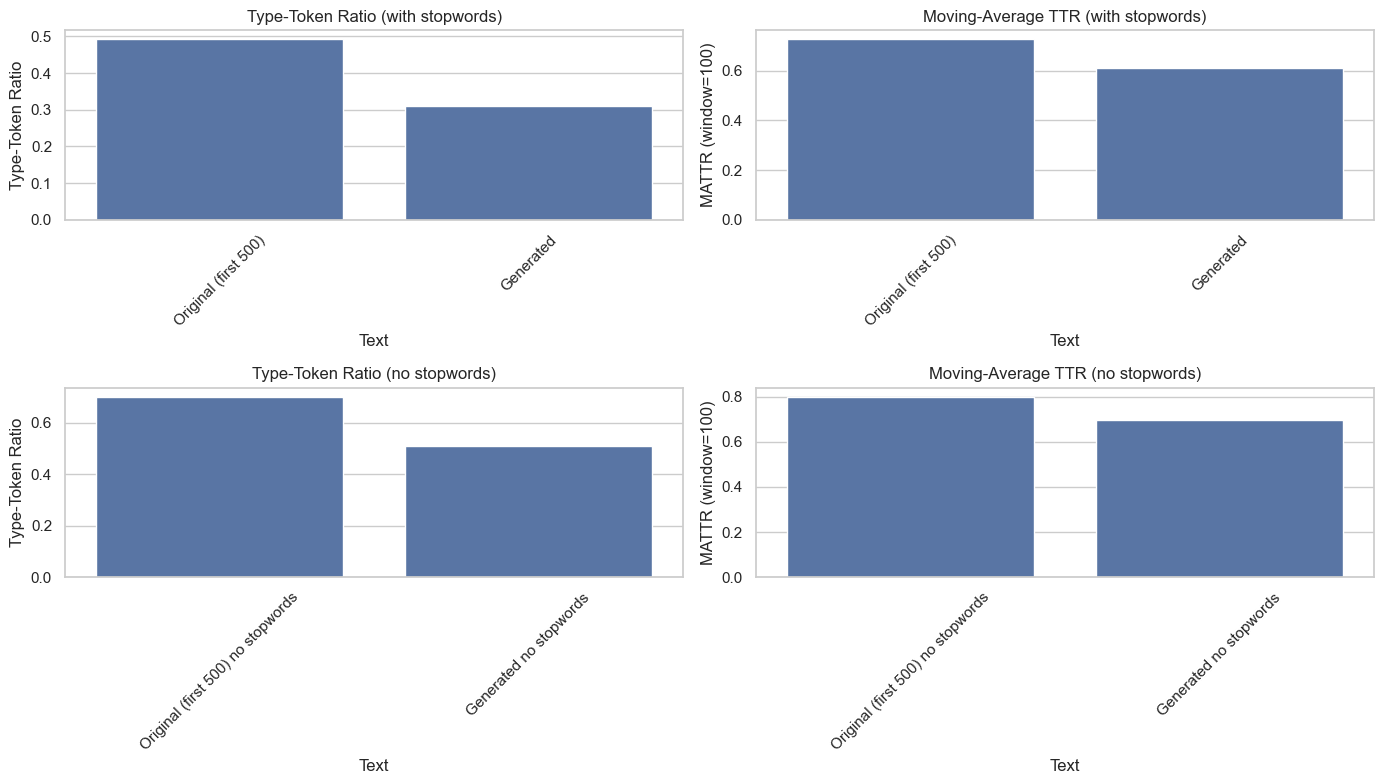

In [7]:
# Visualization setup
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Plot Type-Token Ratio
plt.subplot(2, 2, 1)
sns.barplot(x="Text", y="Type-Token Ratio", data=df_with_stopwords)
plt.title("Type-Token Ratio (with stopwords)")
plt.xticks(rotation=45)

# Plot MATTR
plt.subplot(2, 2, 2)
sns.barplot(x="Text", y="MATTR (window=100)", data=df_with_stopwords)
plt.title("Moving-Average TTR (with stopwords)")
plt.xticks(rotation=45)

# Plot Type-Token Ratio (no stopwords)
plt.subplot(2, 2, 3)
sns.barplot(x="Text", y="Type-Token Ratio", data=df_no_stopwords)
plt.title("Type-Token Ratio (no stopwords)")
plt.xticks(rotation=45)

# Plot MATTR (no stopwords)
plt.subplot(2, 2, 4)
sns.barplot(x="Text", y="MATTR (window=100)", data=df_no_stopwords)
plt.title("Moving-Average TTR (no stopwords)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Word Frequency Analysis

In [8]:
# Get most frequent words (with stopwords removed)
original_freq = word_frequency_distribution(original_tokens_no_stopwords, top_n=15)
generated_freq = word_frequency_distribution(generated_tokens_no_stopwords, top_n=15)

# Create DataFrames for visualization
df_original_freq = pd.DataFrame(original_freq, columns=["Word", "Frequency"])
df_generated_freq = pd.DataFrame(generated_freq, columns=["Word", "Frequency"])

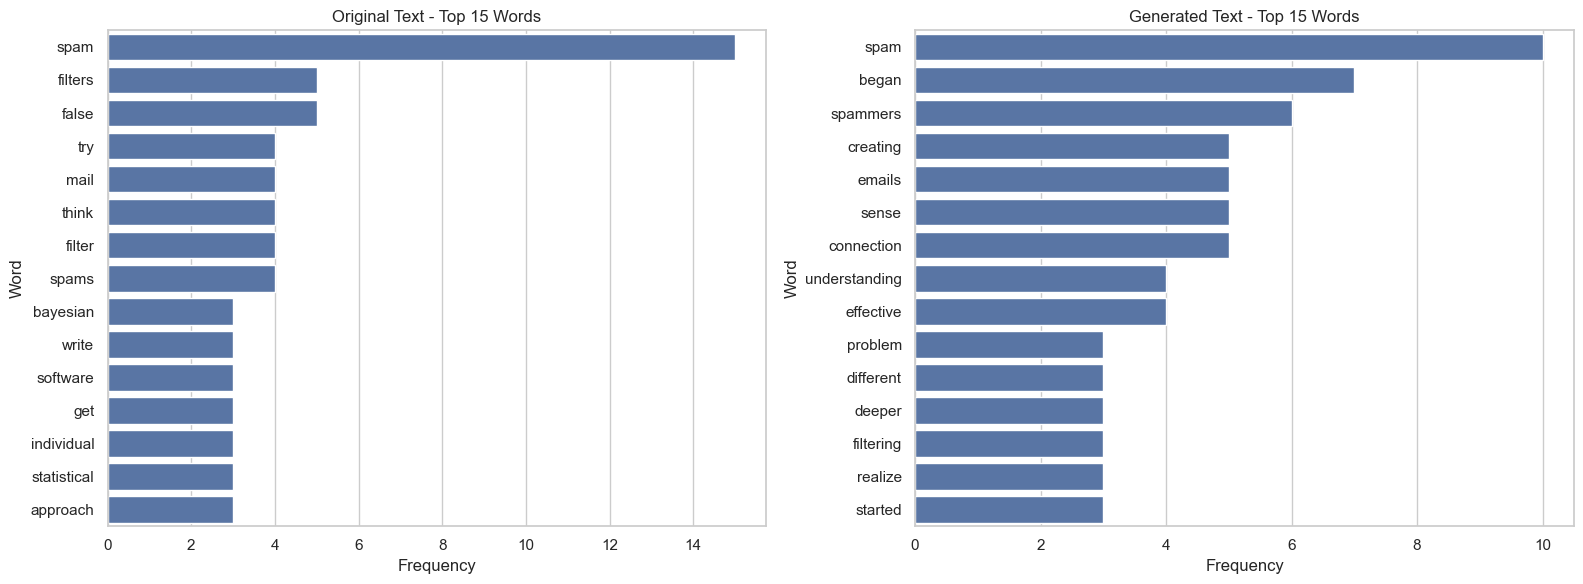

In [9]:
# Plot word frequencies
plt.figure(figsize=(16, 6))

# Original text word frequencies
plt.subplot(1, 2, 1)
sns.barplot(x="Frequency", y="Word", data=df_original_freq)
plt.title("Original Text - Top 15 Words")
plt.xlabel("Frequency")
plt.ylabel("Word")

# Generated text word frequencies
plt.subplot(1, 2, 2)
sns.barplot(x="Frequency", y="Word", data=df_generated_freq)
plt.title("Generated Text - Top 15 Words")
plt.xlabel("Frequency")
plt.ylabel("Word")

plt.tight_layout()
plt.show()

## Integrate the Lexical Diversity Metric into a Compare Function

In [10]:
def lexical_diversity_comparison(text1, text2):
    """Compare the lexical diversity of two texts.
    
    Args:
        text1 (str): First text for comparison
        text2 (str): Second text for comparison
        
    Returns:
        float: A similarity score between 0-1, where 1 indicates identical lexical diversity
        dict: A dictionary with detailed metrics
    """
    # Preprocess texts
    tokens1 = preprocess_text(text1, remove_stopwords=False)
    tokens2 = preprocess_text(text2, remove_stopwords=False)
    
    # Calculate metrics for both texts
    ttr1 = type_token_ratio(tokens1)
    ttr2 = type_token_ratio(tokens2)
    
    mattr1 = moving_average_ttr(tokens1)
    mattr2 = moving_average_ttr(tokens2)
    
    mtld1 = mtld(tokens1)
    mtld2 = mtld(tokens2)
    
    # Calculate similarity scores (1 - normalized absolute difference)
    ttr_sim = 1 - abs(ttr1 - ttr2) / max(ttr1, ttr2) if max(ttr1, ttr2) > 0 else 1
    mattr_sim = 1 - abs(mattr1 - mattr2) / max(mattr1, mattr2) if max(mattr1, mattr2) > 0 else 1
    mtld_sim = 1 - abs(mtld1 - mtld2) / max(mtld1, mtld2) if max(mtld1, mtld2) > 0 else 1
    
    # Calculate overall similarity (weighted average)
    overall_sim = (ttr_sim * 0.3) + (mattr_sim * 0.4) + (mtld_sim * 0.3)
    
    # Return similarity score and detailed metrics
    details = {
        "ttr": {"text1": ttr1, "text2": ttr2, "similarity": ttr_sim},
        "mattr": {"text1": mattr1, "text2": mattr2, "similarity": mattr_sim},
        "mtld": {"text1": mtld1, "text2": mtld2, "similarity": mtld_sim},
        "text1_stats": {"tokens": len(tokens1), "unique_tokens": len(set(tokens1))},
        "text2_stats": {"tokens": len(tokens2), "unique_tokens": len(set(tokens2))}
    }
    
    return overall_sim, details

In [11]:
# Compare original text (first 500 words) with the generated text
similarity, details = lexical_diversity_comparison(first_500, generated_text)

print(f"Lexical Diversity Similarity Score: {similarity:.4f}")
print("\nDetailed Metrics:")
print(f"Type-Token Ratio: {details['ttr']['similarity']:.4f}")
print(f"Moving-Average TTR: {details['mattr']['similarity']:.4f}")
print(f"MTLD: {details['mtld']['similarity']:.4f}")

print("\nText Statistics:")
print(f"Original Text: {details['text1_stats']['tokens']} tokens, {details['text1_stats']['unique_tokens']} unique tokens")
print(f"Generated Text: {details['text2_stats']['tokens']} tokens, {details['text2_stats']['unique_tokens']} unique tokens")

Lexical Diversity Similarity Score: 0.6918

Detailed Metrics:
Type-Token Ratio: 0.6317
Moving-Average TTR: 0.8397
MTLD: 0.5546

Text Statistics:
Original Text: 484 tokens, 238 unique tokens
Generated Text: 470 tokens, 146 unique tokens


In [12]:
# Compare first 500 words with second 500 words of original
intra_similarity, intra_details = lexical_diversity_comparison(first_500, second_500)

print(f"Intra-Text Lexical Diversity Similarity Score: {intra_similarity:.4f}")
print("\nDetailed Metrics:")
print(f"Type-Token Ratio: {intra_details['ttr']['similarity']:.4f}")
print(f"Moving-Average TTR: {intra_details['mattr']['similarity']:.4f}")
print(f"MTLD: {intra_details['mtld']['similarity']:.4f}")

Intra-Text Lexical Diversity Similarity Score: 0.8505

Detailed Metrics:
Type-Token Ratio: 0.9649
Moving-Average TTR: 0.9236
MTLD: 0.6386


## Comparison Summary

Let's summarize the results of our analysis:

In [13]:
summary_data = {
    "Metric": ["LLM Generation vs Original", "Original First 500 vs Second 500"],
    "Overall Similarity": [similarity, intra_similarity],
    "TTR Similarity": [details["ttr"]["similarity"], intra_details["ttr"]["similarity"]],
    "MATTR Similarity": [details["mattr"]["similarity"], intra_details["mattr"]["similarity"]],
    "MTLD Similarity": [details["mtld"]["similarity"], intra_details["mtld"]["similarity"]]
}

summary_df = pd.DataFrame(summary_data)
summary_df

,Metric,Overall Similarity,TTR Similarity,MATTR Similarity,MTLD Similarity
0,LLM Generation vs Original,0.691779,0.631718,0.839718,0.554586
1,Original First 500 vs Second 500,0.850481,0.964885,0.923623,0.638553


<Figure size 1200x600 with 0 Axes>

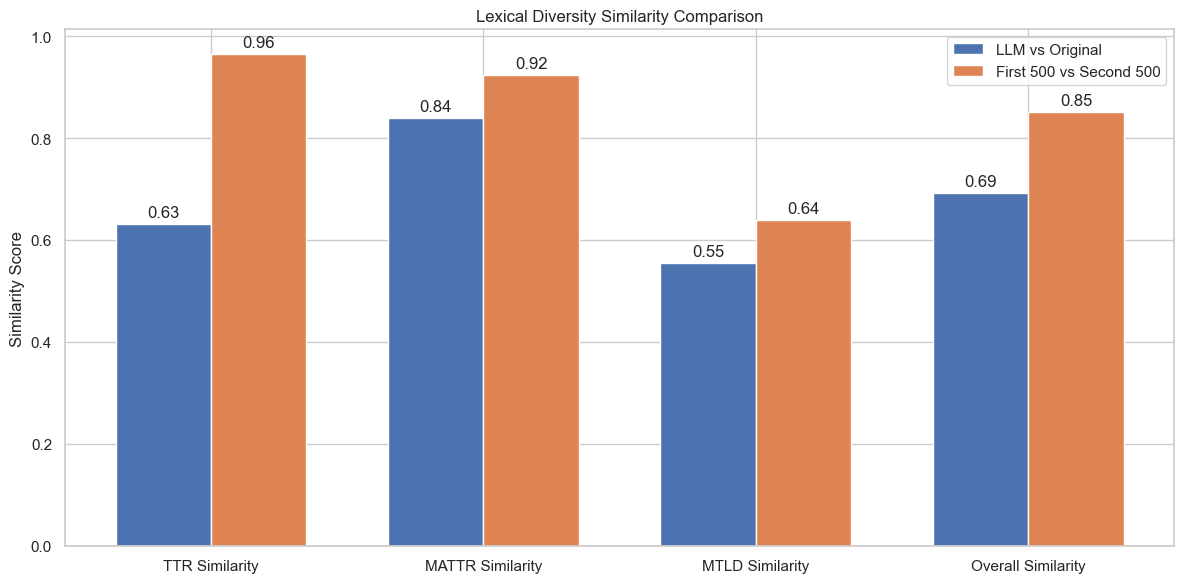

In [14]:
# Visualize the comparison
plt.figure(figsize=(12, 6))

# Get data in format for grouped bar chart
metrics = ["TTR Similarity", "MATTR Similarity", "MTLD Similarity", "Overall Similarity"]
llm_scores = [details["ttr"]["similarity"], details["mattr"]["similarity"], 
              details["mtld"]["similarity"], similarity]
intra_scores = [intra_details["ttr"]["similarity"], intra_details["mattr"]["similarity"], 
                intra_details["mtld"]["similarity"], intra_similarity]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, llm_scores, width, label='LLM vs Original')
rects2 = ax.bar(x + width/2, intra_scores, width, label='First 500 vs Second 500')

ax.set_ylabel('Similarity Score')
ax.set_title('Lexical Diversity Similarity Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

## Conclusion

In this notebook, we defined a new metric for analyzing the lexical diversity of texts. The metric evaluates the vocabulary richness through several measures:

1. **Type-Token Ratio (TTR)**: The ratio of unique words to total words
2. **Moving-Average TTR (MATTR)**: TTR calculated over moving windows to address text length sensitivity
3. **Measure of Textual Lexical Diversity (MTLD)**: A sophisticated measure of lexical diversity

We then compared an original essay with its LLM-generated counterpart using these metrics. The comparison reveals how well the LLM captures the vocabulary richness of the original text. We also compared this similarity to the internal consistency of the original text by measuring the similarity between the first and second 500-word segments.

This analysis provides insights into how well an LLM can mimic the lexical diversity patterns of human-written text, which is an important aspect of style mimicry.